In [1]:
import pandas as pd
ratings = pd.read_csv('data/ratings_small.csv')

In [2]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [3]:
ratings.size

400016

In [4]:
# remove unneccessary fields
ratings = ratings.drop('timestamp', 1)

ratings[ratings.isna().any(axis=1)]


,userId,movieId,rating


In [5]:
len(ratings['userId'].unique())

671

In [6]:
len(ratings['movieId'].unique())

9066

In [7]:
# avg number of anime rated per user
import statistics
ratings_per_user = ratings.groupby('userId')['rating'].count()
statistics.mean(ratings_per_user.tolist())

149.03725782414307

Text(0, 0.5, 'Ratings')

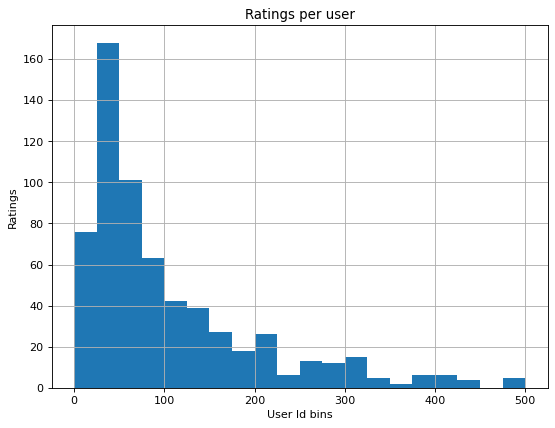

In [8]:
# distribution of ratings per user
# (we may want to exclude users without many data points)
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ratings_per_user.hist(bins=20, range=(0,500))
plt.title("Ratings per user")
plt.xlabel("User Id bins")
plt.ylabel("Ratings")

as mean of ratings per user is around 149, let's get users who has rated more than 149 movies

In [9]:
# counts ratings per user as a df
ratings_per_user_df = pd.DataFrame(ratings_per_user)

filtered_ratings_per_user_df = ratings_per_user_df[ratings_per_user_df.rating >= 149]
# build a list of user_ids to keep
prolific_users = filtered_ratings_per_user_df.index.tolist()

In [10]:
len(prolific_users)

183

In [11]:
# avg number of ratings given per movie
ratings_per_movie = ratings.groupby('movieId')['rating'].count()
statistics.mean(ratings_per_movie.tolist())

11.030664019413193

Text(0, 0.5, 'Ratings')

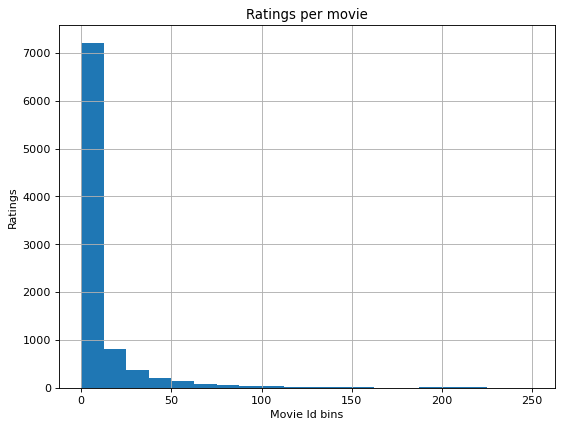

In [12]:
# distribution of ratings per movie

figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ratings_per_movie.hist(bins=20, range=(0,250))
plt.title("Ratings per movie")
plt.xlabel("Movie Id bins")
plt.ylabel("Ratings")

as mean of ratings per user is around 11, let's get movies which has been rated more than 11 times

In [13]:
# counts of ratings per anime as a df
ratings_per_movie_df = pd.DataFrame(ratings_per_movie)
filtered_ratings_per_movie_df = ratings_per_movie_df[ratings_per_movie_df.rating >= 11]
# build a list of anime_ids to keep
popular_movies = filtered_ratings_per_movie_df.index.tolist()

In [14]:
len(popular_movies)

2083

filter out movies and users not in those lists.

In [15]:
filtered_ratings = ratings[ratings.movieId.isin(popular_movies)]
filtered_ratings = ratings[ratings.userId.isin(prolific_users)]
len(filtered_ratings)

71195

400016 -> 71195 ratings; 9066 -> 2083 movies; 671 -> 183 users

In [16]:
rating_matrix = filtered_ratings.pivot_table(index='userId', columns='movieId', values='rating')
# replace NaN values with 0
rating_matrix = rating_matrix.fillna(0)
# display the top few rows
rating_matrix.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,160656,160718,161084,161155,161594,161830,161918,161944,162376,163949
userId,,,,,,,,,,,,,,,,,,,,,
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,2.0,2.0,0.0,0.0,4.5,4.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0
17,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,3.0,3.0,3.0,3.0,0.0,3.0,3.0,0.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
from sklearn.metrics.pairwise import cosine_similarity
import operator
def similar_users(user_id, matrix):
    # create a df of just the current user
    user = matrix[matrix.index == user_id]
    
    # and a df of all other users
    other_users = matrix[matrix.index != user_id]
    
    #userIds
    indices = other_users.index.tolist()
    
    # calc cosine similarity between user and each other user
    similarities = cosine_similarity(user,other_users)[0].tolist()
    similarity_mean = statistics.mean(similarities)
    
    similarities_greater_than_mean = []
    similarities_greater_than_mean_indices = []
    
    for i in range(len(similarities)):
        if(similarities[i] > similarity_mean):
            similarities_greater_than_mean.append(similarities[i]) 
            similarities_greater_than_mean_indices.append(indices[i])
    # create key/values pairs of user index and their similarity
    index_similarity = dict(zip(similarities_greater_than_mean_indices, similarities_greater_than_mean))
    # sort by similarity
    index_similarity_sorted = sorted(index_similarity.items(), key=operator.itemgetter(1))
    index_similarity_sorted.reverse()
    
    users = [u[0] for u in index_similarity_sorted]
    
    return users

In [18]:
from sklearn.metrics.pairwise import cosine_similarity
import operator
def dissimilar_users(user_id, matrix):
    # create a df of just the current user
    user = matrix[matrix.index == user_id]
    
    # and a df of all other users
    other_users = matrix[matrix.index != user_id]
    
    #userIds
    indices = other_users.index.tolist()
    
    # calc cosine similarity between user and each other user
    similarities = cosine_similarity(user,other_users)[0].tolist()
    similarity_mean = statistics.mean(similarities)
    
    similarities_less_than_mean = []
    similarities_less_than_mean_indices = []
    
    for i in range(len(similarities)):
        if(similarities[i] < similarity_mean):
            similarities_less_than_mean.append(similarities[i]) 
            similarities_less_than_mean_indices.append(indices[i])
    # create key/values pairs of user index and their similarity
    index_similarity = dict(zip(similarities_less_than_mean_indices, similarities_less_than_mean))
    # sort by similarity
    index_similarity_sorted = sorted(index_similarity.items(), key=operator.itemgetter(1))
    index_similarity_sorted.reverse()
    
    users = [u[0] for u in index_similarity_sorted]
    
    return users

In [19]:
prolific_users

[4,
 15,
 17,
 19,
 21,
 22,
 23,
 26,
 30,
 34,
 41,
 48,
 56,
 57,
 61,
 72,
 73,
 77,
 78,
 81,
 83,
 86,
 88,
 91,
 93,
 94,
 95,
 99,
 102,
 105,
 111,
 118,
 119,
 125,
 128,
 130,
 133,
 134,
 149,
 150,
 152,
 157,
 165,
 176,
 177,
 185,
 187,
 189,
 195,
 199,
 200,
 205,
 212,
 213,
 214,
 220,
 232,
 235,
 236,
 239,
 240,
 242,
 243,
 247,
 250,
 253,
 262,
 265,
 268,
 270,
 275,
 283,
 285,
 287,
 292,
 294,
 295,
 299,
 303,
 306,
 311,
 312,
 313,
 324,
 328,
 342,
 344,
 345,
 346,
 350,
 353,
 355,
 358,
 363,
 367,
 371,
 373,
 380,
 382,
 384,
 387,
 388,
 390,
 394,
 402,
 405,
 407,
 408,
 412,
 418,
 423,
 426,
 427,
 428,
 430,
 431,
 433,
 434,
 439,
 442,
 452,
 457,
 460,
 461,
 463,
 466,
 468,
 471,
 472,
 475,
 480,
 481,
 487,
 500,
 501,
 505,
 509,
 510,
 514,
 516,
 518,
 519,
 520,
 522,
 529,
 533,
 534,
 537,
 544,
 547,
 553,
 558,
 561,
 562,
 563,
 564,
 574,
 575,
 577,
 580,
 584,
 585,
 587,
 595,
 596,
 597,
 598,
 599,
 605,
 607,
 608,
 61

In [20]:
current_user =  648 # 294
# try it out
similar_user_indices_sample = similar_users(current_user, rating_matrix)
print(len(similar_user_indices_sample))
print(similar_user_indices_sample)

82
[283, 596, 430, 580, 457, 481, 94, 152, 23, 355, 303, 26, 72, 509, 627, 544, 574, 433, 125, 562, 105, 501, 212, 428, 442, 615, 73, 664, 15, 78, 520, 268, 380, 48, 17, 519, 88, 345, 461, 253, 353, 388, 468, 77, 607, 584, 522, 431, 56, 262, 480, 423, 426, 313, 654, 130, 295, 452, 165, 561, 220, 384, 472, 475, 598, 427, 394, 407, 243, 134, 624, 500, 157, 324, 292, 22, 187, 547, 587, 460, 563, 149]


In [21]:
# matrix = rating_matrix
# user_id = 294
# user = matrix[matrix.index == user_id]
# # and a df of all other users
# other_users = matrix[matrix.index != user_id]
# other_users  
# # calc cosine similarity between user and each other user
# similarities = cosine_similarity(user,other_users)[0].tolist()
# indices = other_users.index.tolist()

# similarity_mean = statistics.mean(similarities)
# indices = other_users.index.tolist()
# similarities_less_than_mean = []
# similarities_less_than_mean_indices = []
# for i in range(len(similarities)):
#     if(similarities[i] > similarity_mean):
#     similarities_less_than_mean.append(similarities[i]) 
#     similarities_less_than_mean_indices.append(indices[i])
# print(len(similarities_less_than_mean_indices))
# print(len(similarities_less_than_mean))

# # create key/values pairs of user index and their similarity
# index_similarity = dict(zip(similarities_less_than_mean_indices, similarities_less_than_mean))
# # sort by similarity
# index_similarity_sorted = sorted(index_similarity.items(), key=operator.itemgetter(1))
# index_similarity_sorted.reverse()
# users = [u[0] for u in index_similarity_sorted]
# users
# #     # grab k users off the top
# #     top_users_dissimilarities = index_similarity_sorted[:len(similarities_less_than_mean)]
# #     users = [u[0] for u in top_users_dissimilarities]

In [22]:
dissimilar_user_indices_sample = dissimilar_users(current_user, rating_matrix)
print(len(dissimilar_user_indices_sample))
print(dissimilar_user_indices_sample)

100
[119, 199, 240, 608, 150, 285, 200, 111, 408, 350, 418, 19, 463, 275, 21, 505, 358, 299, 176, 373, 553, 647, 514, 195, 577, 250, 270, 214, 99, 83, 93, 34, 30, 344, 236, 434, 620, 665, 371, 185, 235, 529, 133, 242, 232, 312, 382, 471, 57, 585, 306, 412, 102, 510, 534, 294, 595, 61, 387, 247, 564, 328, 311, 81, 466, 177, 402, 118, 558, 439, 487, 342, 518, 346, 516, 205, 4, 597, 265, 189, 128, 367, 213, 390, 86, 95, 533, 239, 605, 575, 537, 91, 405, 287, 363, 599, 646, 626, 41, 652]


In [23]:
similar_set = set(similar_user_indices_sample)
dissimilar_set = set(dissimilar_user_indices_sample)
common_elements = similar_set.intersection(dissimilar_user_indices_sample)
len(common_elements)

0

In [24]:
#adding new users

In [25]:
user_1_ratings = ratings[ratings.userId == 1]

In [26]:
new_user_df = pd.DataFrame([user_1_ratings['rating'].tolist()], columns=user_1_ratings['movieId'].tolist())

In [27]:
s = new_user_df.xs(0)

s.name = 1
rating_matrix = rating_matrix.append(s)
rating_matrix = rating_matrix.fillna(0)
rating_matrix

,1,2,3,4,5,6,7,8,9,10,...,160656,160718,161084,161155,161594,161830,161918,161944,162376,163949
userId,,,,,,,,,,,,,,,,,,,,,
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,2.0,2.0,0.0,0.0,4.5,4.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0
17,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,3.0,3.0,3.0,3.0,0.0,3.0,3.0,0.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
652,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
654,5.0,3.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
664,3.5,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
new_user = 1
# try it out
similar_user_indices_new_user = similar_users(new_user, rating_matrix)
print(len(similar_user_indices_new_user))
print(similar_user_indices_new_user)

76
[195, 130, 102, 119, 387, 575, 468, 510, 232, 214, 73, 19, 34, 585, 518, 363, 564, 605, 580, 472, 4, 509, 461, 452, 654, 463, 265, 23, 533, 95, 587, 41, 373, 346, 405, 529, 607, 57, 118, 105, 380, 577, 30, 311, 534, 15, 624, 285, 306, 547, 21, 358, 423, 77, 212, 646, 185, 505, 514, 312, 303, 466, 561, 647, 294, 133, 608, 665, 22, 457, 390, 537, 56, 150, 430, 283]


In [29]:
#movie data processing

In [30]:
similar_user_indices_sample_ratings = ratings[ratings.userId.isin(similar_user_indices_sample)]
similar_user_indices_sample_ratings

,userId,movieId,rating
962,15,1,2.0
963,15,2,2.0
964,15,5,4.5
965,15,6,4.0
966,15,10,3.0
...,...,...,...
99254,664,116797,4.0
99255,664,122882,4.0
99256,664,122892,5.0
99257,664,122900,4.5


In [31]:
from wordcloud import WordCloud

def plotWordCountsBasedOnColumnValuesAndUsers(user_indices, col_name, movies):
    user_indices_ratings = ratings[ratings.userId.isin(user_indices)]

    user_ratings_per_movie = user_indices_ratings[user_indices_ratings.rating > 4].groupby('movieId')['rating'].count()
    mean = statistics.mean(user_ratings_per_movie.tolist())
    user_ratings_per_movie_df = pd.DataFrame(user_ratings_per_movie)
    print(mean)
    filtered_user_ratings_per_movie_df = user_ratings_per_movie_df[user_ratings_per_movie_df.rating > mean]
    movieIds = filtered_user_ratings_per_movie_df.index.tolist()
    len(movieIds)

    sample_movies = movies[movies.id.isin(movieIds)]

    counts = sample_movies[col_name].value_counts()
    counts = counts[counts > statistics.mean(counts)]
    counts = counts[:10]

    wordcloud = WordCloud().generate_from_frequencies(counts)

    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

C:\Users\Pubudu.C\new\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


3.2109025915996425


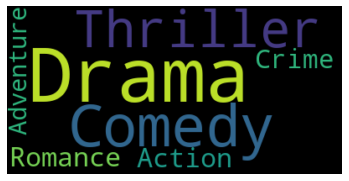

In [32]:
movies = pd.read_csv('data/movies_exploded_genres.csv')
plotWordCountsBasedOnColumnValuesAndUsers(similar_user_indices_sample, 'genres_names', movies)

2.9122029802658074


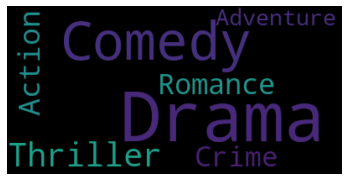

In [33]:
plotWordCountsBasedOnColumnValuesAndUsers(dissimilar_user_indices_sample, 'genres_names', movies)

3.2109025915996425


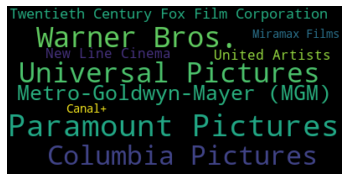

In [34]:
movies = pd.read_csv('data/movies_exploded_production_companies.csv')
plotWordCountsBasedOnColumnValuesAndUsers(similar_user_indices_sample, 'production_companies_list', movies)

2.9122029802658074


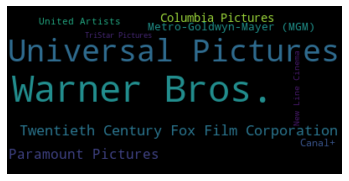

In [35]:
plotWordCountsBasedOnColumnValuesAndUsers(dissimilar_user_indices_sample, 'production_companies_list', movies)

3.2109025915996425


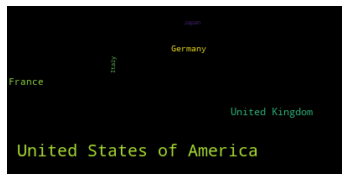

2.9122029802658074


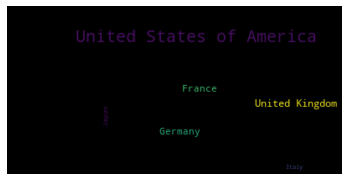

In [36]:
movies = pd.read_csv('data/movies_exploded_production_countries.csv')
plotWordCountsBasedOnColumnValuesAndUsers(similar_user_indices_sample, 'production_countries_list', movies)
plotWordCountsBasedOnColumnValuesAndUsers(dissimilar_user_indices_sample, 'production_countries_list', movies)

3.2109025915996425


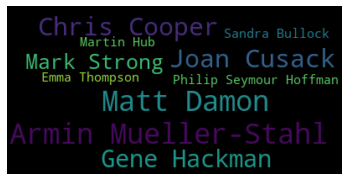

2.9122029802658074


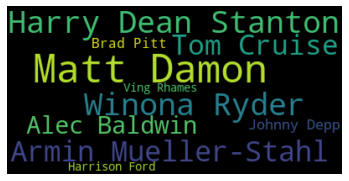

In [37]:
credits = pd.read_csv('data/credits_exploded_actors.csv')
plotWordCountsBasedOnColumnValuesAndUsers(similar_user_indices_sample, 'actors', credits)
plotWordCountsBasedOnColumnValuesAndUsers(dissimilar_user_indices_sample, 'actors', credits)

3.2109025915996425


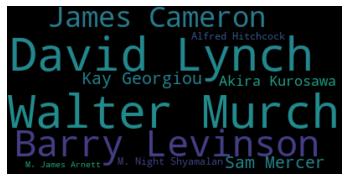

2.9122029802658074


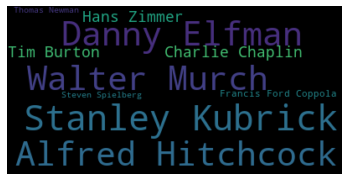

In [38]:
credits = pd.read_csv('data/credits_exploded_crew.csv')
plotWordCountsBasedOnColumnValuesAndUsers(similar_user_indices_sample, 'crew_people', credits)
plotWordCountsBasedOnColumnValuesAndUsers(dissimilar_user_indices_sample, 'crew_people', credits)

3.2109025915996425


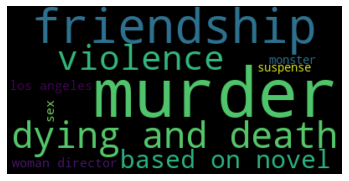

2.9122029802658074


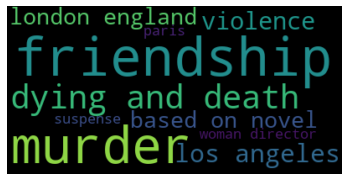

In [39]:
keywords = pd.read_csv('data/keywords_exploded_name.csv')
plotWordCountsBasedOnColumnValuesAndUsers(similar_user_indices_sample, 'keywords_names', keywords)
plotWordCountsBasedOnColumnValuesAndUsers(dissimilar_user_indices_sample, 'keywords_names', keywords)

In [40]:
def getCountsSeries(user_indices, col_name, movies):
    user_indices_ratings = ratings[ratings.userId.isin(user_indices)]

    user_ratings_per_movie = user_indices_ratings[user_indices_ratings.rating > 4].groupby('movieId')['rating'].count()
    mean = statistics.mean(user_ratings_per_movie.tolist())
    user_ratings_per_movie_df = pd.DataFrame(user_ratings_per_movie)
    filtered_user_ratings_per_movie_df = user_ratings_per_movie_df[user_ratings_per_movie_df.rating > mean]
    movieIds = filtered_user_ratings_per_movie_df.index.tolist()

    sample_movies = movies[movies.id.isin(movieIds)]

    counts = sample_movies[col_name].value_counts()
    counts = counts[counts > statistics.mean(counts)]
    return counts

In [41]:
getCountsSeries(similar_user_indices_sample, 'keywords_names', keywords)

murder             13
friendship         12
dying and death    11
violence           10
based on novel     10
                   ..
petrol              2
forest              2
adoption            2
mutation            2
netherlands         2
Name: keywords_names, Length: 295, dtype: int64

In [42]:
getCountsSeries(dissimilar_user_indices_sample, 'keywords_names', keywords)

friendship         24
murder             22
dying and death    17
los angeles        16
violence           15
                   ..
manager             2
surfer              2
flat                2
pet                 2
minefield           2
Name: keywords_names, Length: 665, dtype: int64

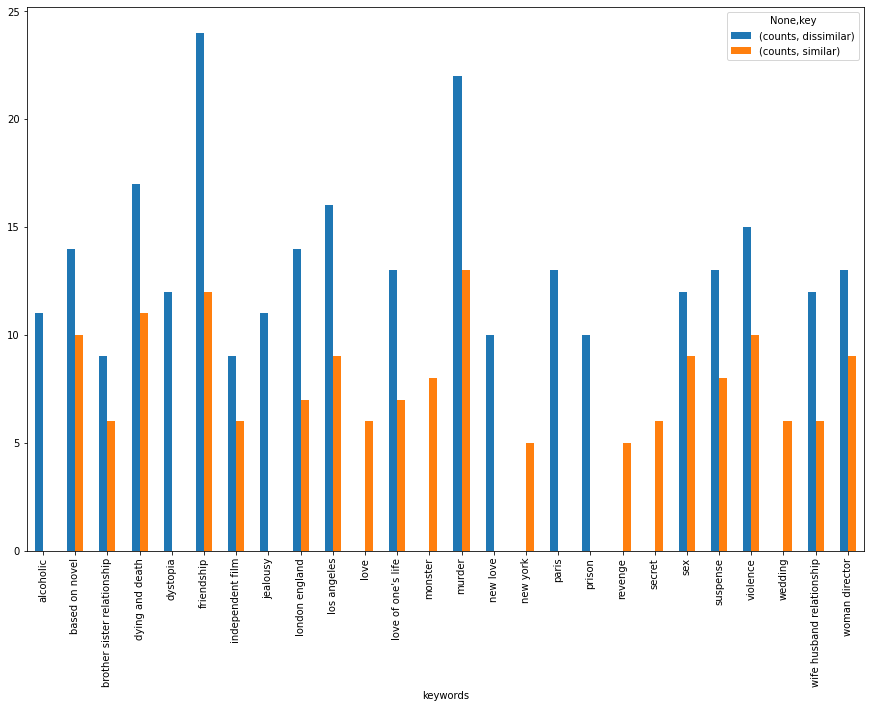

In [43]:
similar_user_df = getCountsSeries(similar_user_indices_sample, 'keywords_names', keywords)[:20].rename_axis('keywords').reset_index(name='counts')
dissimilar_user_df = getCountsSeries(dissimilar_user_indices_sample, 'keywords_names', keywords)[:20].rename_axis('keywords').reset_index(name='counts')

similar_user_df['key'] = 'similar'
dissimilar_user_df['key'] = 'dissimilar'

DF = pd.concat([similar_user_df,dissimilar_user_df],keys=['similar','dissimilar'])

DFGroup = DF.groupby(['keywords','key'])

DFGPlot = DFGroup.sum().unstack('key').plot(kind='bar',  figsize=(15,10))

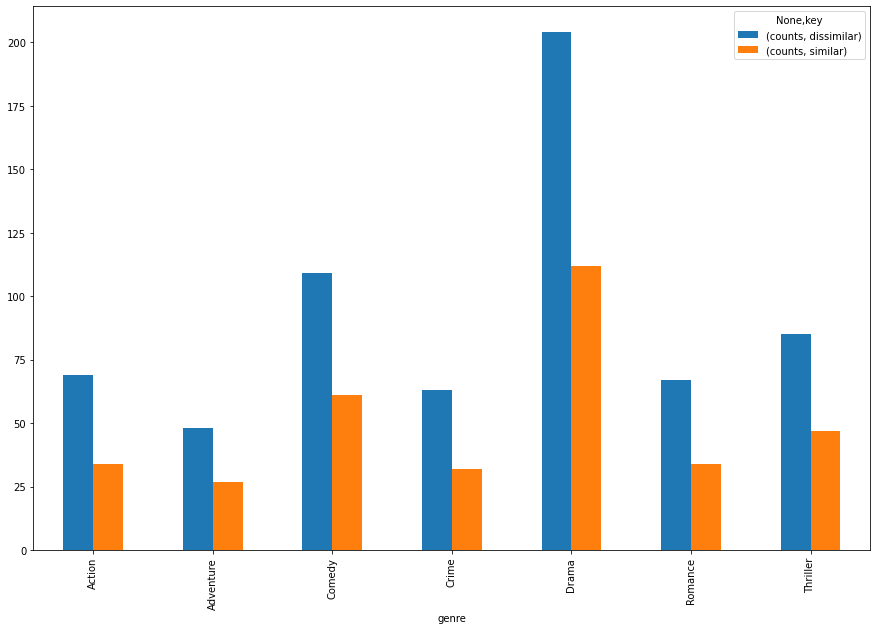

In [44]:
movies = pd.read_csv('data/movies_exploded_genres.csv')

similar_user_df = getCountsSeries(similar_user_indices_sample, 'genres_names', movies).rename_axis('genre').reset_index(name='counts')
dissimilar_user_df = getCountsSeries(dissimilar_user_indices_sample, 'genres_names', movies).rename_axis('genre').reset_index(name='counts')

similar_user_df['key'] = 'similar'
dissimilar_user_df['key'] = 'dissimilar'

DF = pd.concat([similar_user_df,dissimilar_user_df],keys=['similar','dissimilar'])

DFGroup = DF.groupby(['genre','key'])

DFGPlot = DFGroup.sum().unstack('key').plot(kind='bar',  figsize=(15,10))

In [45]:
# getCountsSeries(similar_user_indices_sample, 'genres_names', movies)

In [46]:
# randomly pick dissimilar user 270 let's see his similar group and their preferences
dissimilar_user_similar_group = similar_users(270, rating_matrix)
print(len(dissimilar_user_similar_group))
print(dissimilar_user_similar_group)

80
[615, 72, 475, 553, 664, 48, 380, 157, 73, 199, 149, 563, 15, 94, 402, 26, 428, 433, 544, 250, 56, 624, 287, 574, 152, 205, 91, 584, 519, 501, 134, 212, 176, 480, 125, 426, 384, 620, 580, 481, 355, 457, 213, 78, 268, 561, 88, 522, 324, 353, 562, 200, 187, 423, 520, 275, 22, 61, 430, 345, 262, 627, 133, 599, 394, 596, 461, 607, 77, 431, 547, 371, 303, 17, 598, 292, 23, 654, 468, 150]


C:\Users\Pubudu.C\new\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


3.0545708955223883


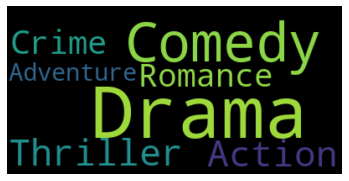

In [47]:
movies = pd.read_csv('data/movies_exploded_genres.csv')
plotWordCountsBasedOnColumnValuesAndUsers(dissimilar_user_similar_group, 'genres_names', movies)

3.0545708955223883


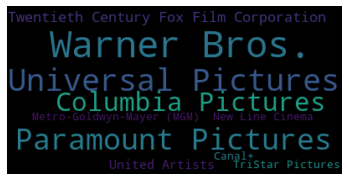

In [48]:
movies = pd.read_csv('data/movies_exploded_production_companies.csv')
plotWordCountsBasedOnColumnValuesAndUsers(dissimilar_user_similar_group, 'production_companies_list', movies)

3.0545708955223883


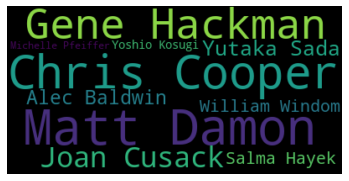

In [49]:
credits = pd.read_csv('data/credits_exploded_actors.csv')
plotWordCountsBasedOnColumnValuesAndUsers(dissimilar_user_similar_group, 'actors', credits)

3.0545708955223883


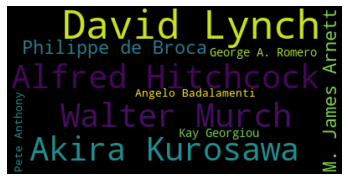

In [50]:
credits = pd.read_csv('data/credits_exploded_crew.csv')
plotWordCountsBasedOnColumnValuesAndUsers(dissimilar_user_similar_group, 'crew_people', credits)

3.0545708955223883


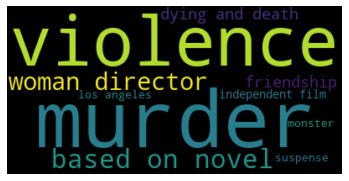

In [51]:
keywords = pd.read_csv('data/keywords_exploded_name.csv')
plotWordCountsBasedOnColumnValuesAndUsers(dissimilar_user_similar_group, 'keywords_names', keywords)

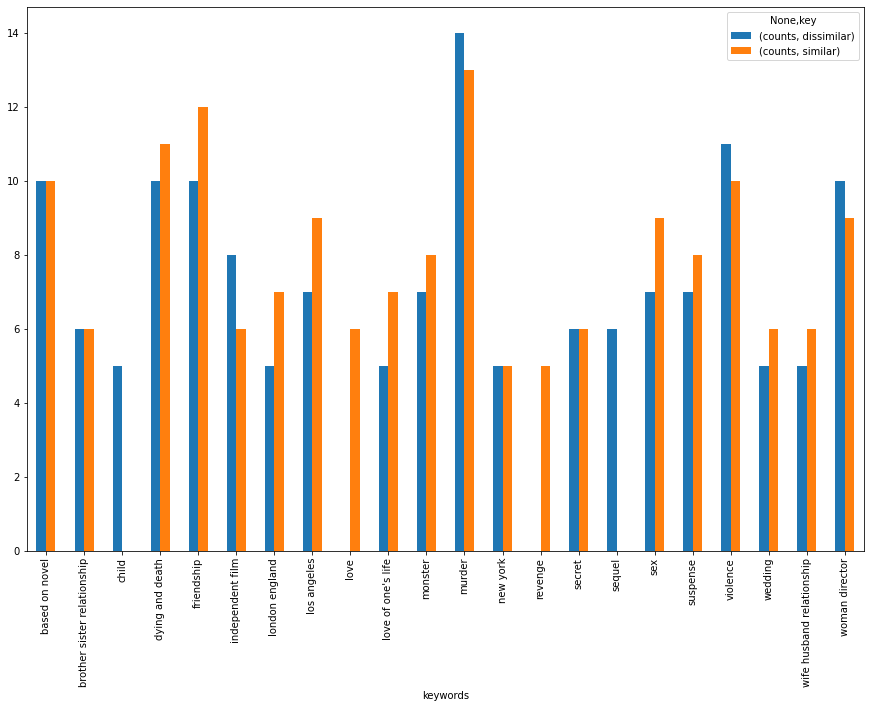

In [52]:
similar_user_df = getCountsSeries(similar_user_indices_sample, 'keywords_names', keywords)[:20].rename_axis('keywords').reset_index(name='counts')
dissimilar_user_df = getCountsSeries(dissimilar_user_similar_group, 'keywords_names', keywords)[:20].rename_axis('keywords').reset_index(name='counts')

similar_user_df['key'] = 'similar'
dissimilar_user_df['key'] = 'dissimilar'

DF = pd.concat([similar_user_df,dissimilar_user_df],keys=['similar','dissimilar'])

DFGroup = DF.groupby(['keywords','key'])

DFGPlot = DFGroup.sum().unstack('key').plot(kind='bar',  figsize=(15,10))